In [0]:
!pip install -q lightgbm skforecast

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.plot import (
    set_dark_theme, 
    plot_prediction_intervals, 
    backtesting_gif_creator
)
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skforecast.plot import plot_residuals

# Define custom metrics
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

def rmsse(y_true, y_pred, y_train):
    """Root Mean Squared Scaled Error"""
    naive_error = np.mean((y_train[1:] - y_train[:-1]) ** 2)
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse / (naive_error + 1e-8))

def check_date_continuity(data, products, product_colname, freq='D', verbose=False):
    """Check date continuity per product in a DataFrame.
    
    Parameters:
    - data: pd.DataFrame with 'date' (datetime) and product_colname columns.
    - products: list of product names.
    - product_colname: str, column name for product IDs.
    - freq: str, time series frequency (default: 'D').
    - verbose: bool, if True, print missing dates.
    
    Returns:
    - dict: {product: {'is_continuous': bool, 'missing_dates': list or None}}
    """
    assert pd.api.types.is_datetime64_any_dtype(data['date']), "'date' must be datetime."
    results = {}
    for prod in products:
        dates = data[data[product_colname] == prod]['date'].sort_values()
        expected = pd.date_range(dates.min(), dates.max(), freq=freq)
        missing = [d for d in expected if d not in dates.values]
        is_continuous = not missing
        results[prod] = {'is_continuous': is_continuous, 'missing_dates': missing or None}
        print(f"\nProduct: {prod}\n  Continuous: {is_continuous}")
        if verbose and missing:
            print(f"  Missing Dates: {missing}")
    return results

def plot_time_series_by_product(data, products, product_colname="product", variables=['sales', 'temp']):
    """
    Automatic function to plot time series for visualization and exploration by product.
    
    Parameters:
    - data: pd.DataFrame with time series data, including 'date' and product_colname columns.
    - products: list of product names to plot.
    - product_colname: str, name of the column containing product identifiers.
    - variables: list of variables to plot (e.g., ['sales', 'temp']).
    """
    for prod in products:
        # Filter data for the current product using product_colname
        df_prod = data[data[product_colname] == prod].set_index('date')
        
        # Create figure and primary axis
        fig, ax1 = plt.subplots(figsize=(14, 7))
        
        # Plot primary variable (first in variables, e.g., 'sales')
        primary_var = variables[0]
        ax1.plot(df_prod.index, df_prod[primary_var], color='blue', label=primary_var.capitalize())
        ax1.set_xlabel('Date')
        ax1.set_ylabel(primary_var.capitalize(), color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        # For additional variables (e.g., 'temp'), use secondary axis if more than one variable
        if len(variables) > 1:
            for var in variables[1:]:
                ax2 = ax1.twinx()
                ax2.plot(df_prod.index, df_prod[var], color='green', label=var.capitalize(), alpha=0.7)
                ax2.set_ylabel(var.capitalize(), color='green')
                ax2.tick_params(axis='y', labelcolor='green')
                # Combine legends
                lines1, labels1 = ax1.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        else:
            ax1.legend(loc='upper left')
        
        plt.title(f'Time Series Exploration for {prod}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def predict_insample(forecaster, y, exog=None):
    X, y_true = forecaster.create_train_X_y(y=y, exog=exog)
    predictions = forecaster.regressor.predict(X)
    return pd.Series(predictions, index=y_true.index, name='in_sample_pred')

In [0]:
# Simulate time series data
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', end='2022-09-25', freq='D')  # Approx 1000 days
n_days = len(dates)
products = ['Product_A', 'Product_B', 'Product_C']

# Exogenous variables (shared across products)
temp = np.random.normal(20, 5, n_days)
holiday = np.random.choice([0, 1], n_days, p=[0.9, 0.1])

# Generate sales for each product with trend, seasonality, noise, and exog effects
data_list = []
for prod in products:
    trend = np.linspace(100, 200, n_days) if prod == 'Product_A' else np.linspace(50, 150, n_days) if prod == 'Product_B' else np.linspace(200, 300, n_days)
    seasonality = 20 * np.sin(2 * np.pi * np.arange(n_days) / 365)
    noise = np.random.normal(0, 10, n_days)
    exog_effect = 2 * temp + 50 * holiday
    sales = trend + seasonality + noise + exog_effect
    df_prod = pd.DataFrame({
        'date': dates,
        'product': prod,
        'sales': sales,
        'temp': temp,
        'holiday': holiday
    })
    data_list.append(df_prod)

data = pd.concat(data_list).reset_index(drop=True)

# Prepare future exogenous for predictions (30 days ahead)
future_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=30, freq='D')
future_temp = np.random.normal(20, 5, 30)
future_holiday = np.random.choice([0, 1], 30, p=[0.9, 0.1])
future_exog = pd.DataFrame({
    'temp': future_temp,
    'holiday': future_holiday
}, index=future_dates)

# Parameters and checks

In [0]:
# Backtesting parameters
lags = 14  # Lags for autoregression
n_steps = 7  # Forecast horizon for backtesting
perc_training = 0.8 # 80% for initial train
n_boot_param_val = 10 # less than 100 less robust but high speed for PoC or Tests

y_colname = "sales"
id_col = "product"
date_col = "date"
freq="D"
exog_list = ['temp', 'holiday']

# Metrics to compute
metrics_list = ['MAE', 'MSE', 'SMAPE']

In [0]:
date_dataquality = check_date_continuity(data, products, product_colname=id_col, freq=freq, verbose=True)
pd.DataFrame.from_dict(date_dataquality).T.reset_index()


Product: Product_A
  Continuous: True

Product: Product_B
  Continuous: True

Product: Product_C
  Continuous: True


,index,is_continuous,missing_dates
0,Product_A,True,None
1,Product_B,True,None
2,Product_C,True,None


In [0]:
# number of events
data.groupby(id_col).count()

,date,sales,temp,holiday
product,,,,
Product_A,999,999,999,999
Product_B,999,999,999,999
Product_C,999,999,999,999


In [0]:
# Hero Skus
data.groupby(id_col)[y_colname].sum().reset_index().round().sort_values(by=y_colname, ascending=False)

,product,sales
2,Product_C,295805.0
0,Product_A,195754.0
1,Product_B,145655.0


In [0]:
data.groupby(id_col)[y_colname].sum().reset_index().assign(**{'percent': lambda x: (x[y_colname] / x[y_colname].sum() * 100).round(2)}).sort_values(by=y_colname, ascending=False)

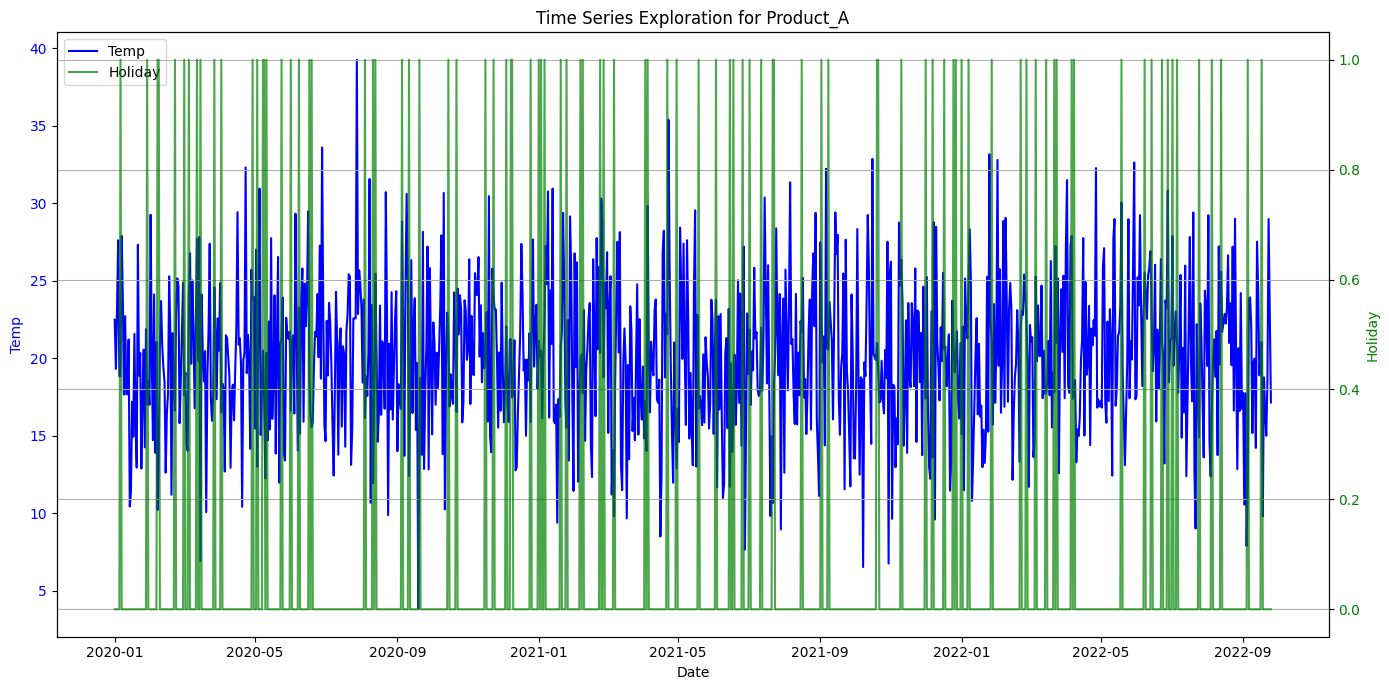

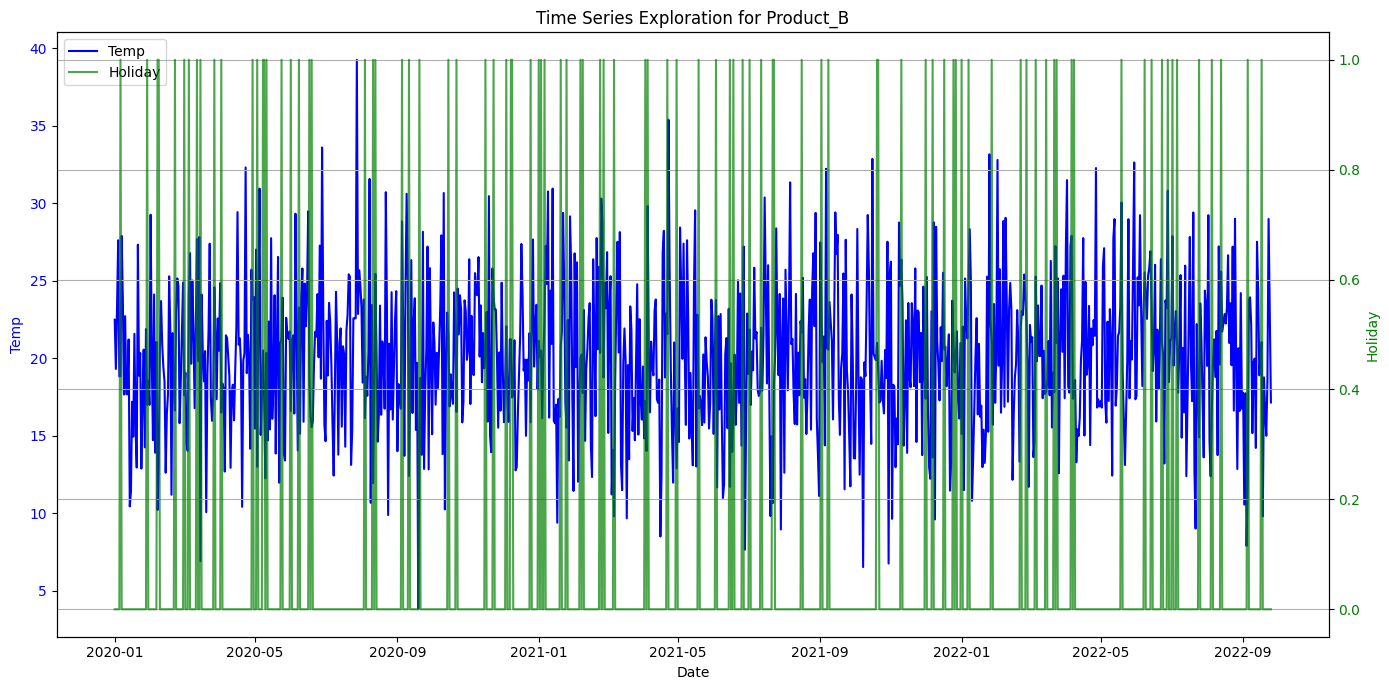

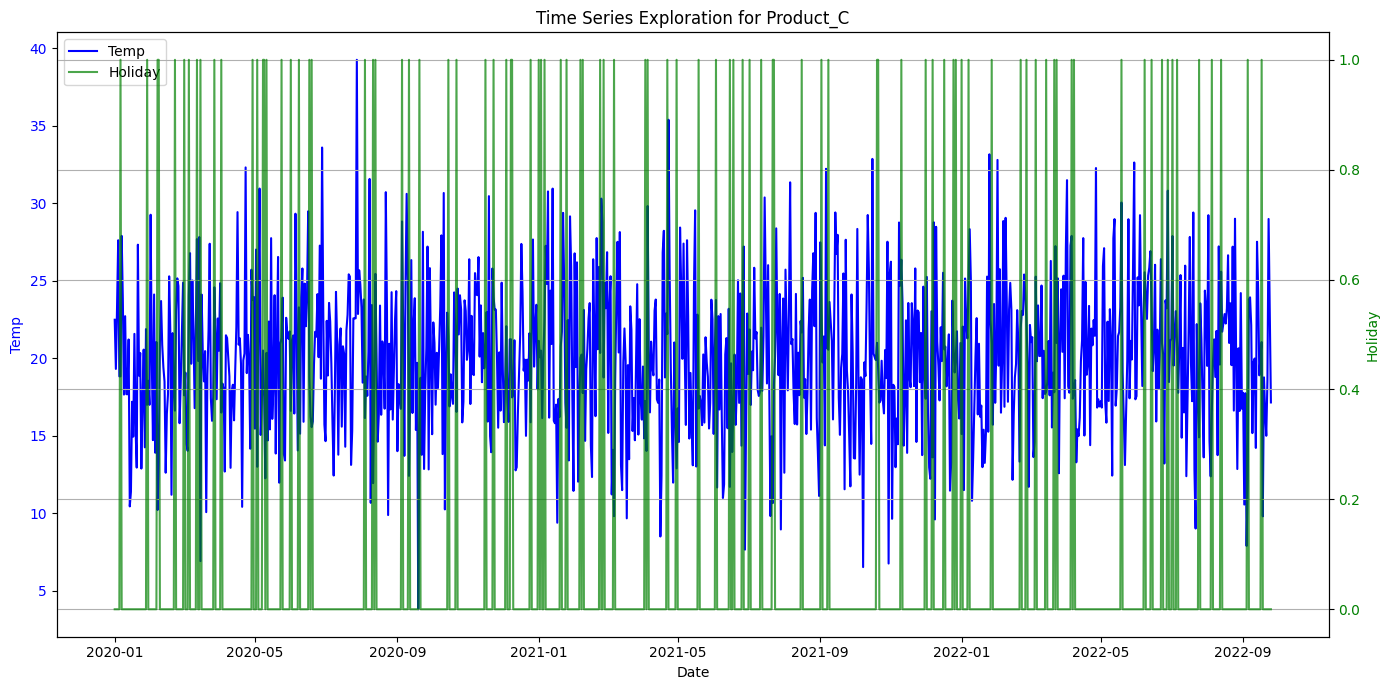

In [0]:
# Call the plotting function
plot_time_series_by_product(
    data=data, 
    products=products, 
    product_colname=id_col, 
    variables=exog_list)

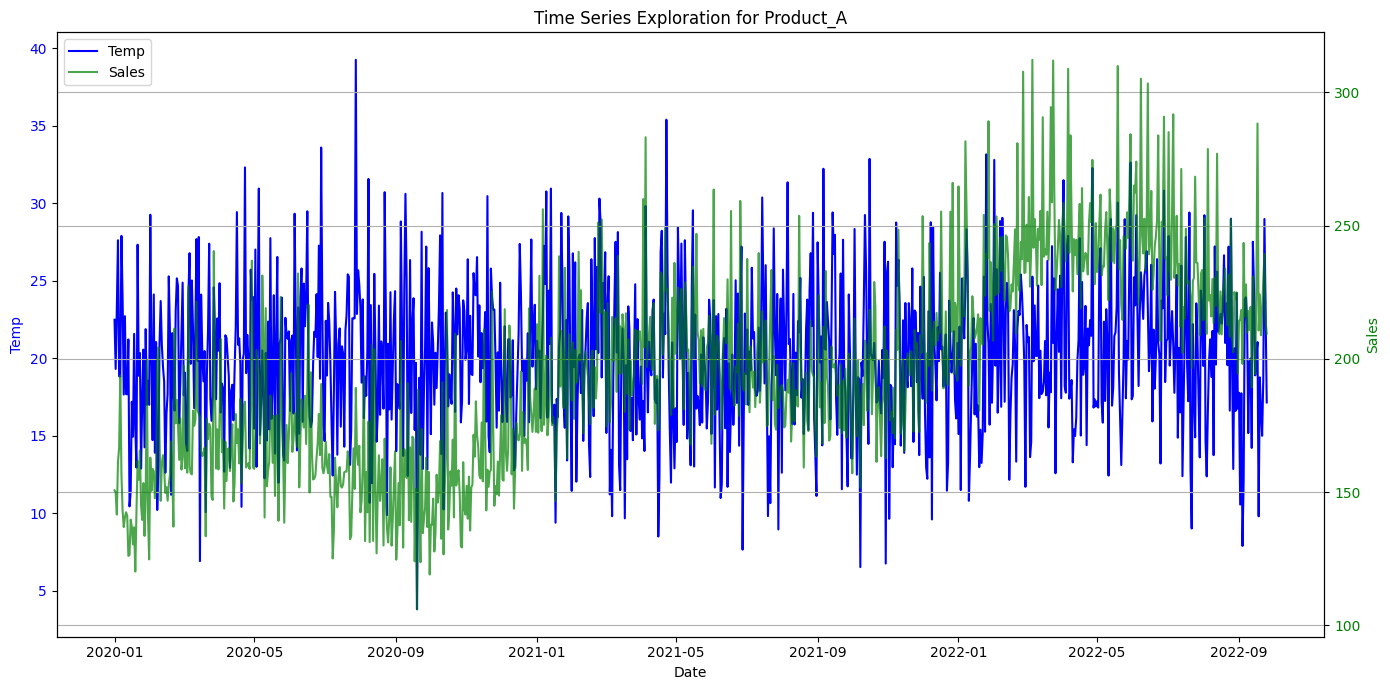

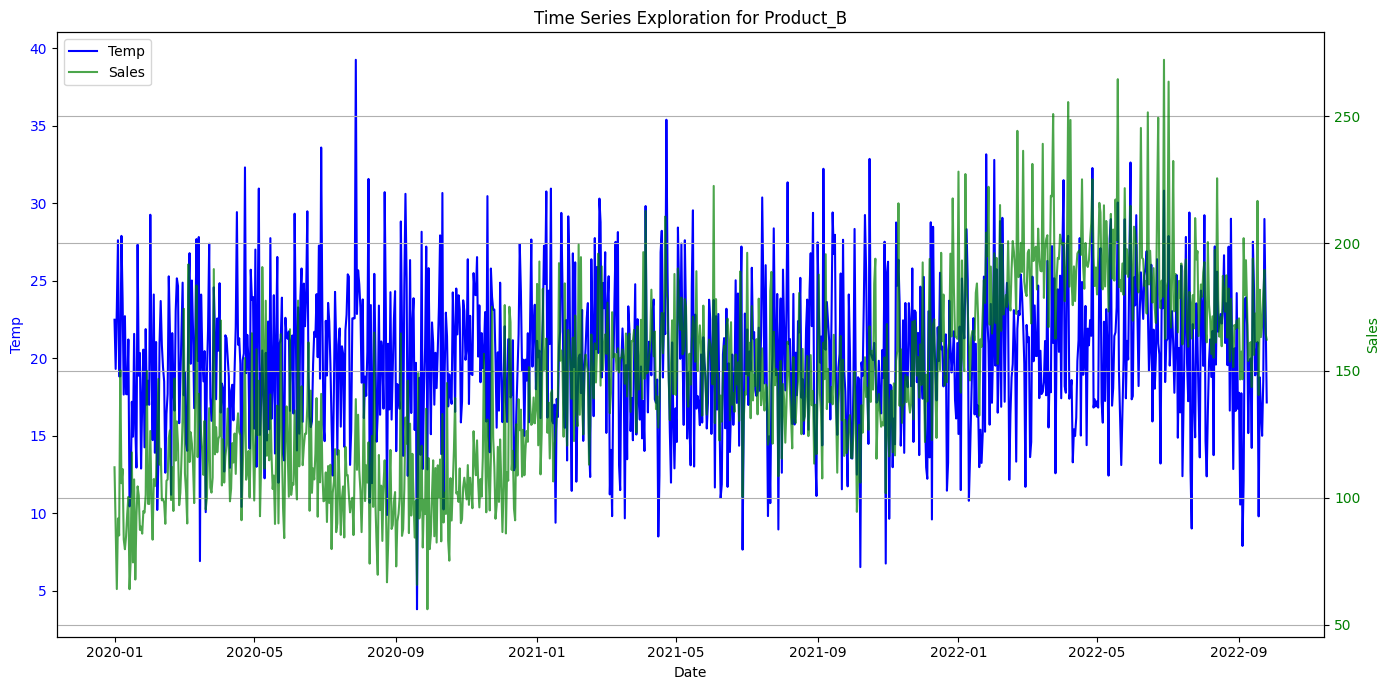

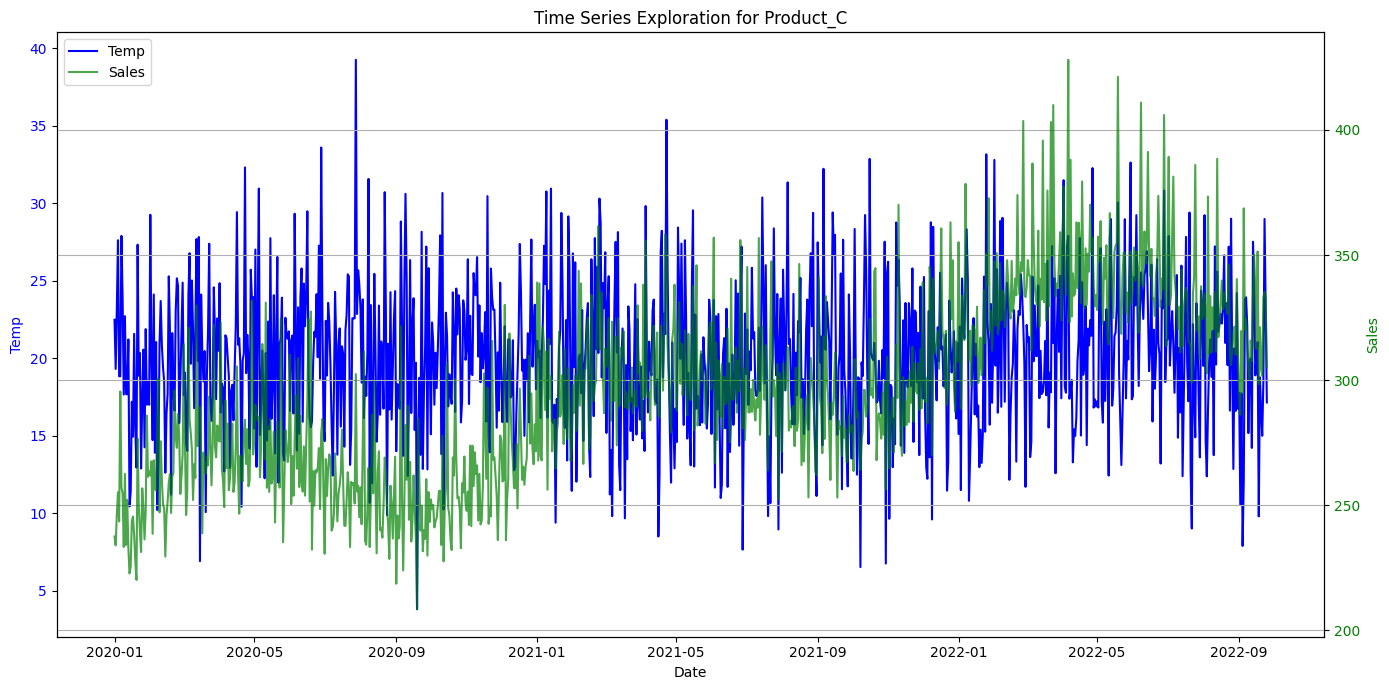

In [0]:
# Call the plotting function
plot_time_series_by_product(
    data=data, 
    products=products, 
    product_colname=id_col, 
    variables=[exog_list[0]]+[y_colname])

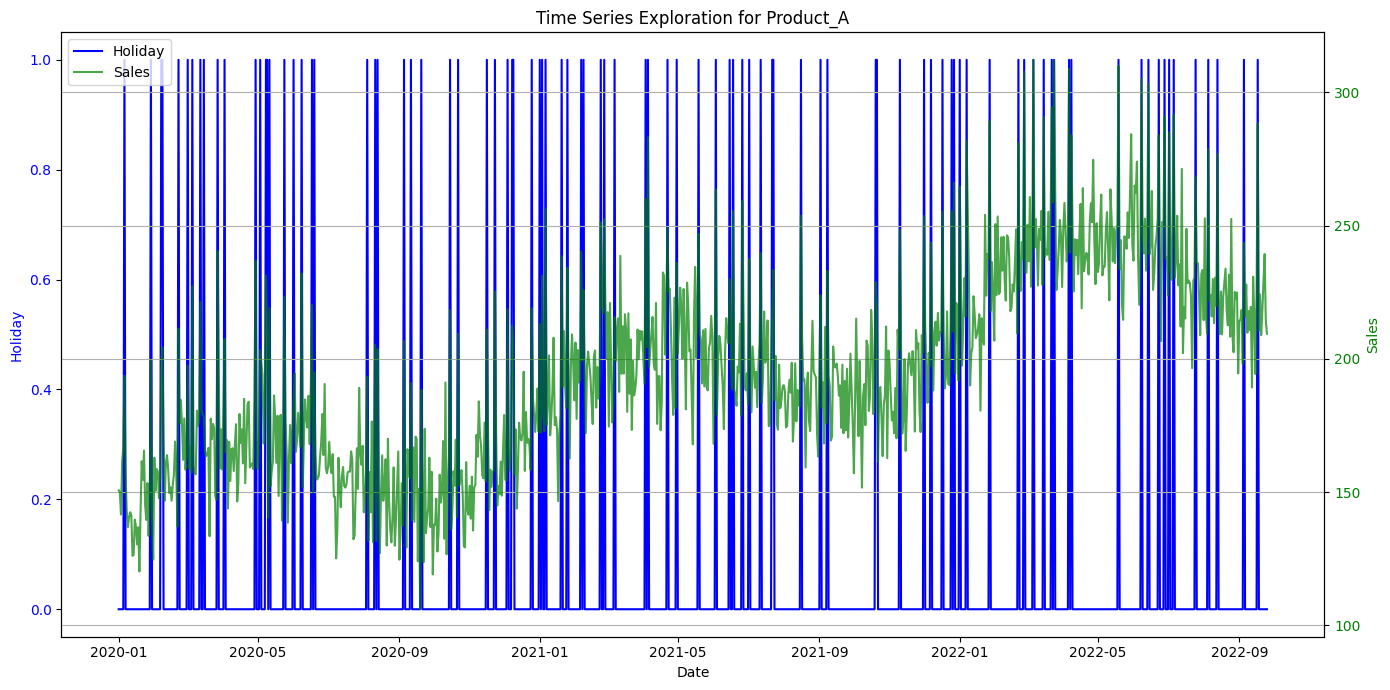

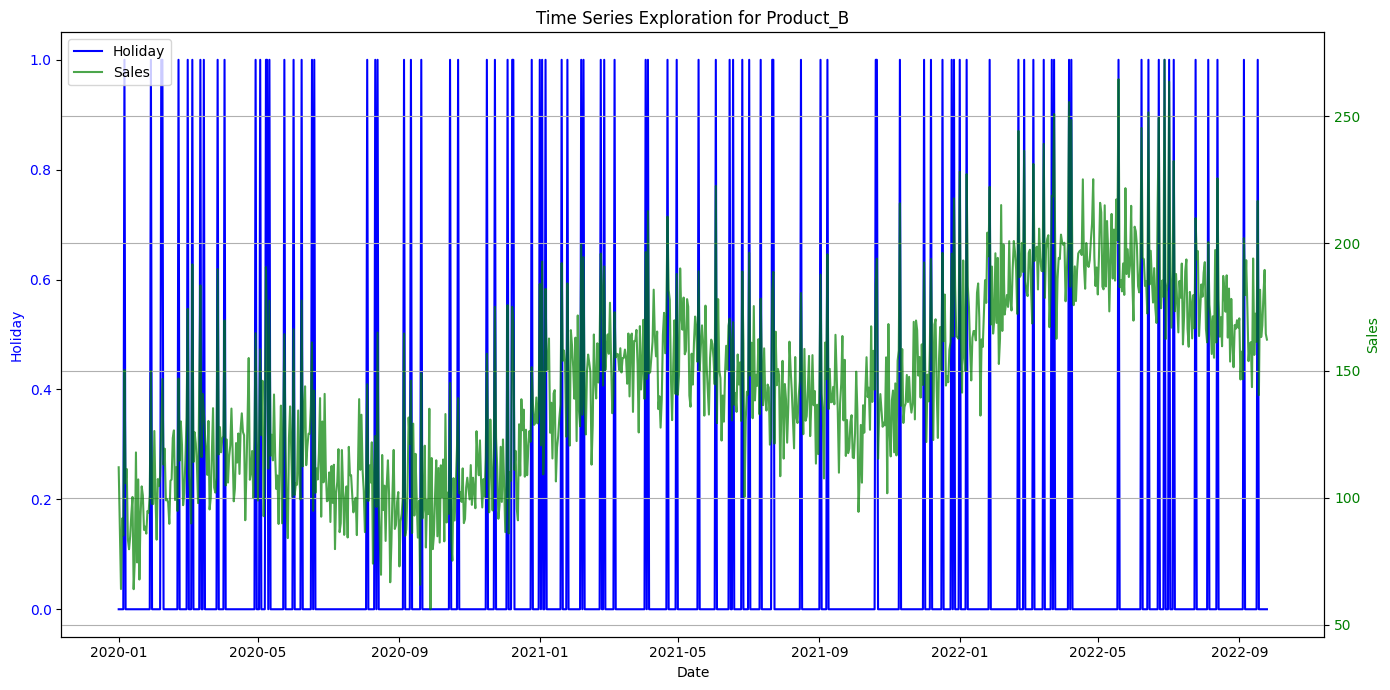

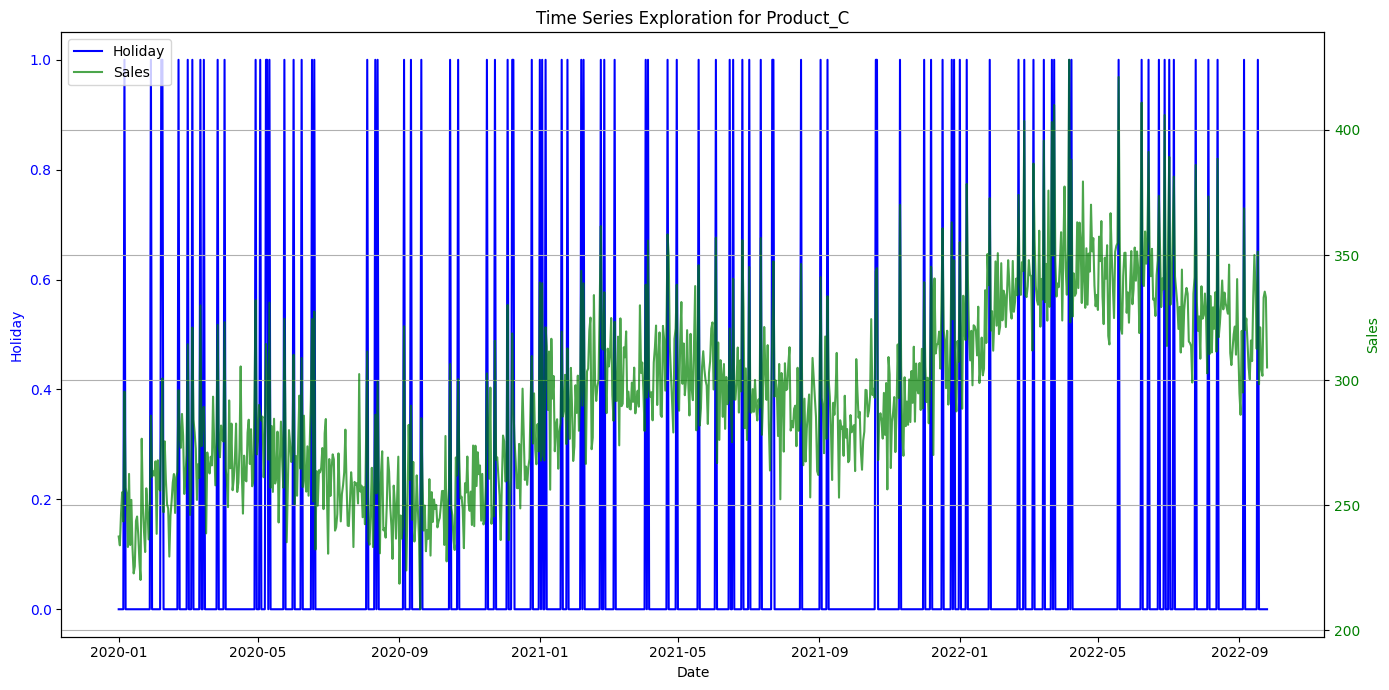

In [0]:
# Call the plotting function
plot_time_series_by_product(
    data=data, 
    products=products, 
    product_colname=id_col, 
    variables=[exog_list[1]]+[y_colname])

# Backtesting

In this step, we validate the model using a sliding window approach with incremental retraining enabled. This setup closely simulates a real-world scenario where new data continuously arrives alongside historical data, and the model is periodically evaluated over time.

In [0]:
# List to store metrics per product
results = []

for prod in products:
    print(f"\nBacktesting for {prod}")
    df_prod = data[data[id_col] == prod].set_index(date_col)
    y = df_prod[y_colname]
    initial_train_size = int(len(y) * perc_training)
    y.index.freq = pd.infer_freq(y.index) if y.index.freq is None else y.index.freq
    exog = df_prod[exog_list]
    
    forecaster = ForecasterRecursive(
        regressor=LGBMRegressor(random_state=42, verbose=-1),
        window_features=RollingFeatures(stats=['mean'], window_sizes=[n_steps, lags]),
        lags=lags)

    # The TimeSeriesFold class is designed to generate the partitions used in the backtesting process to train and evaluate the model.     
    cv = TimeSeriesFold(
        steps                 = n_steps,
        initial_train_size    = initial_train_size,
        refit                 = True,
        fixed_train_size      = False,
        gap                   = 0,
        allow_incomplete_fold  = True
    )
    
    # Backtesting
    metric, predictions = backtesting_forecaster(
        forecaster    = forecaster,
        y             = y,
        cv            = cv,
        metric        = ['mean_absolute_error', 'mean_squared_error', smape],
        n_jobs        = 'auto',
        verbose       = False,
        show_progress = True
    )
    
    # Create a dictionary for the current product's metrics
    metric_dict = {'id_col': prod}
    metric_dict.update(metric.iloc[0].to_dict())  # Extract the first (and only) row of metric as a dict
    results.append(metric_dict)

# Summary table
summary_df = pd.DataFrame(results)


Backtesting for Product_A


  0%|          | 0/29 [00:00<?, ?it/s]


Backtesting for Product_B


  0%|          | 0/29 [00:00<?, ?it/s]


Backtesting for Product_C


  0%|          | 0/29 [00:00<?, ?it/s]

In [0]:
summary_df.round(2)

,id_col,mean_absolute_error,mean_squared_error,smape
0,Product_A,17.97,527.83,7.43
1,Product_B,16.88,505.91,8.78
2,Product_C,18.15,574.22,5.29


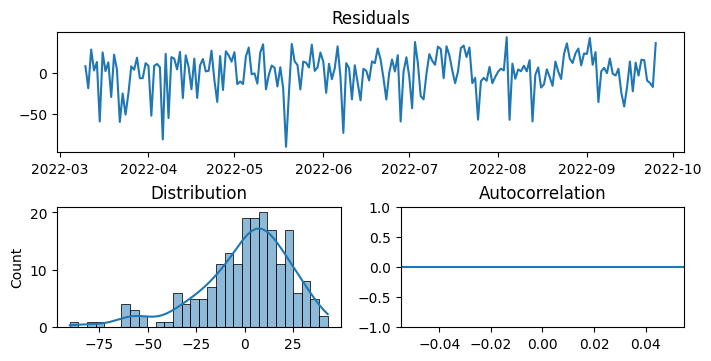

In [0]:
# Check residuals
residuals = predictions['pred'] - y
_ = plot_residuals(residuals=residuals, figsize=(7, 3.5))

# In production Model - simulation
## Future forecast & Prediction Intervals

After estimating the backtested error, we can set **expectations** for future performance. Since past results don’t guarantee future accuracy—especially long term—we retrain the model on the full time series to keep it updated. We also assess in-sample error and estimate **uncertainty** at a 90% confidence level. This helps us go **beyond accuracy**, incorporating **risk** factors like over- or understocking. By quantifying uncertainty, we can better explain model behavior to the business and build **trust**.


Training and Predicting for Product_A


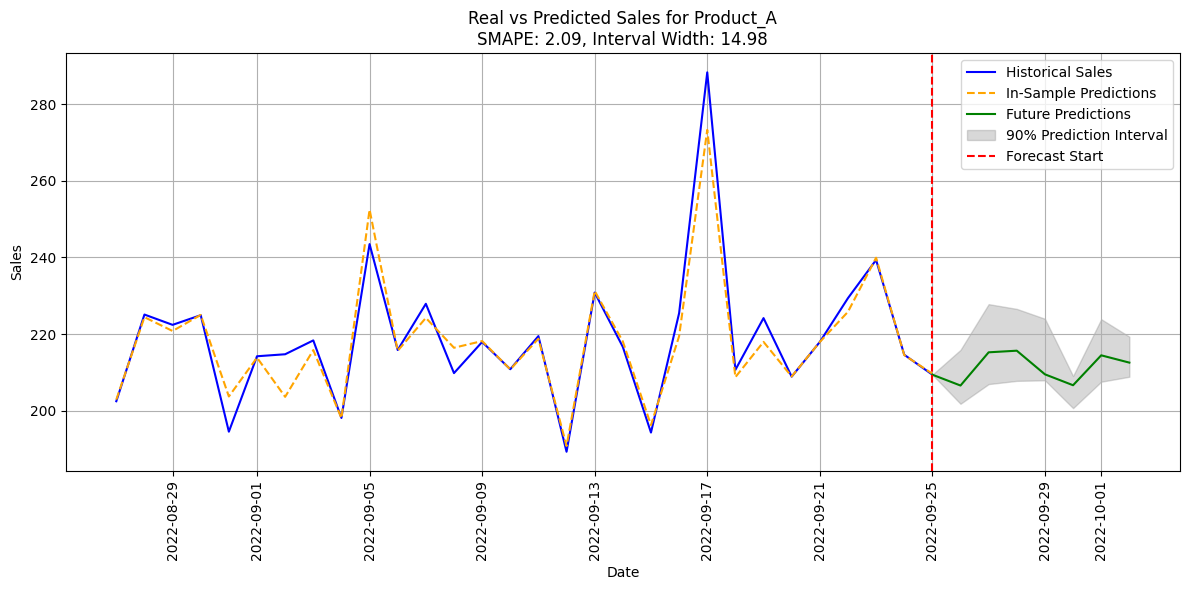


Training and Predicting for Product_B


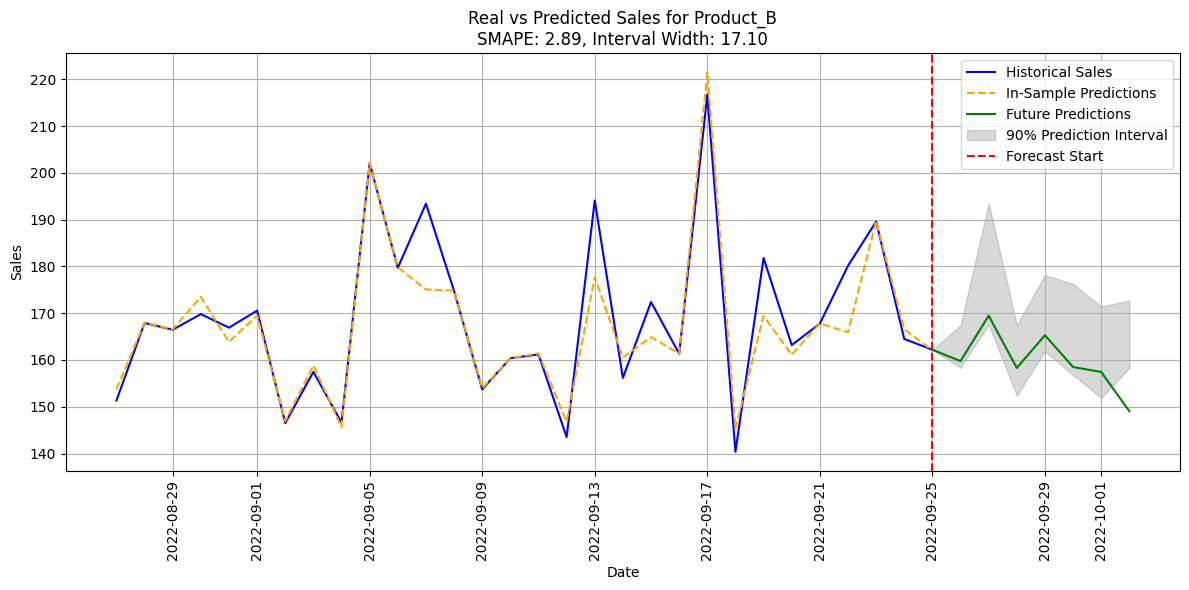


Training and Predicting for Product_C


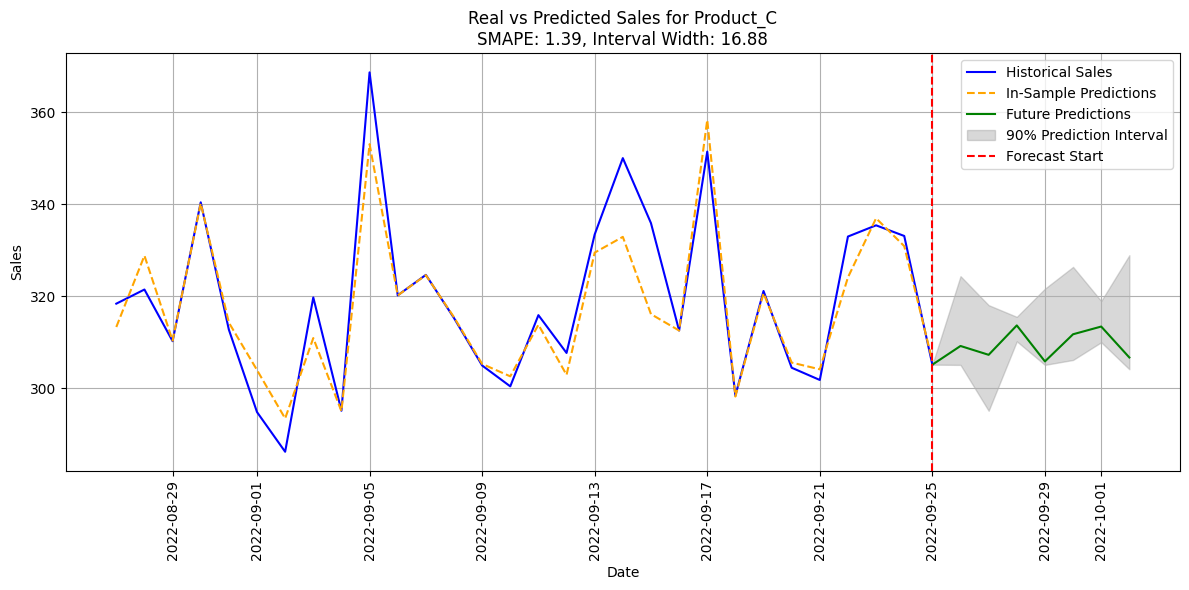

In [0]:
# Assuming `data`, `products`, `lags`, and `n_steps` are defined
for prod in products:
    print(f"\nTraining and Predicting for {prod}")
    # Filter product data and set index
    df_prod = data[data[id_col] == prod].set_index(date_col)
    y = df_prod[y_colname]
    y.index.freq = pd.infer_freq(y.index) if y.index.freq is None else y.index.freq
    exog = df_prod[exog_list]

    # Initialize forecaster with additional rolling features
    forecaster_median = ForecasterRecursive(
        regressor=LGBMRegressor(objective='quantile', alpha=0.5, random_state=42, verbose=-1),
        lags=lags,
        window_features=RollingFeatures(stats=['mean', 'std'], window_sizes=[n_steps, lags])
    )

    # Fit the model
    forecaster_median.fit(y=y, exog=exog, store_in_sample_residuals=True)

    # Generate in-sample predictions
    in_sample_predictions = predict_insample(forecaster_median, y=y, exog=exog)

    # Convert to DataFrame for comparison
    in_sample_df = pd.DataFrame({
        'actual': y,
        'predicted': in_sample_predictions
    }, index=y.index)

    # Calculate RMSE for in-sample predictions
    smape_res = smape(in_sample_df['actual'], in_sample_df['predicted'])

    # Prepare future exogenous variables
    last_date = y.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_steps, freq=y.index.freq)
    exog_future = pd.concat([exog.iloc[-1:]] * n_steps, axis=0)
    exog_future.index = future_dates

    # Generate out-of-sample predictions with intervals
    predictions = forecaster_median.predict_interval(
        steps=n_steps,
        exog=exog_future,
        interval=[5, 95],  # 90% prediction intervals
        n_boot=n_boot_param_val
    )

    # Calculate average interval width
    interval_width = (predictions['upper_bound'] - predictions['lower_bound']).mean()

    # Plot with seamless connection
    plt.figure(figsize=(12, 6))
    plt.plot(y[-30:], label='Historical Sales', color='blue')
    plt.plot(y.index[-30:], in_sample_predictions[-30:], label='In-Sample Predictions', color='orange', linestyle='--')
    # Prepend last actual value directly in plot
    pred_dates = [last_date] + list(predictions.index)
    pred_values = [y.iloc[-1]] + list(predictions['pred'])
    lower_bound = [y.iloc[-1]] + list(predictions['lower_bound'])
    upper_bound = [y.iloc[-1]] + list(predictions['upper_bound'])
    plt.plot(pred_dates, pred_values, label='Future Predictions', color='green')
    plt.fill_between(pred_dates, lower_bound, upper_bound, color='gray', alpha=0.3, label='90% Prediction Interval')
    plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
    plt.title(f"Real vs Predicted Sales for {prod}\nSMAPE: {smape_res:.2f}, Interval Width: {interval_width:.2f}")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()